**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [1]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
import pandas as pd
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)#读取数据
#调用模块
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()

dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)
Gap30 = dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

Initialize dataview success.
Initialize dataview success.


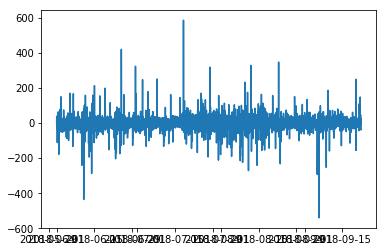

In [2]:
#30min
import matplotlib.pyplot as plt

plt.plot(dv30M.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

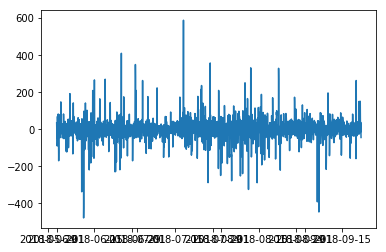

In [3]:
#1h
plt.plot(dv1H.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

/anaconda3/envs/python36/lib/python3.6/site-packages/jaqs/data/py_expression_eval.py:477: RuntimeWarning: invalid value encountered in greater
  res = arr > brr
/anaconda3/envs/python36/lib/python3.6/site-packages/jaqs/data/py_expression_eval.py:486: RuntimeWarning: invalid value encountered in less
  res = arr < brr


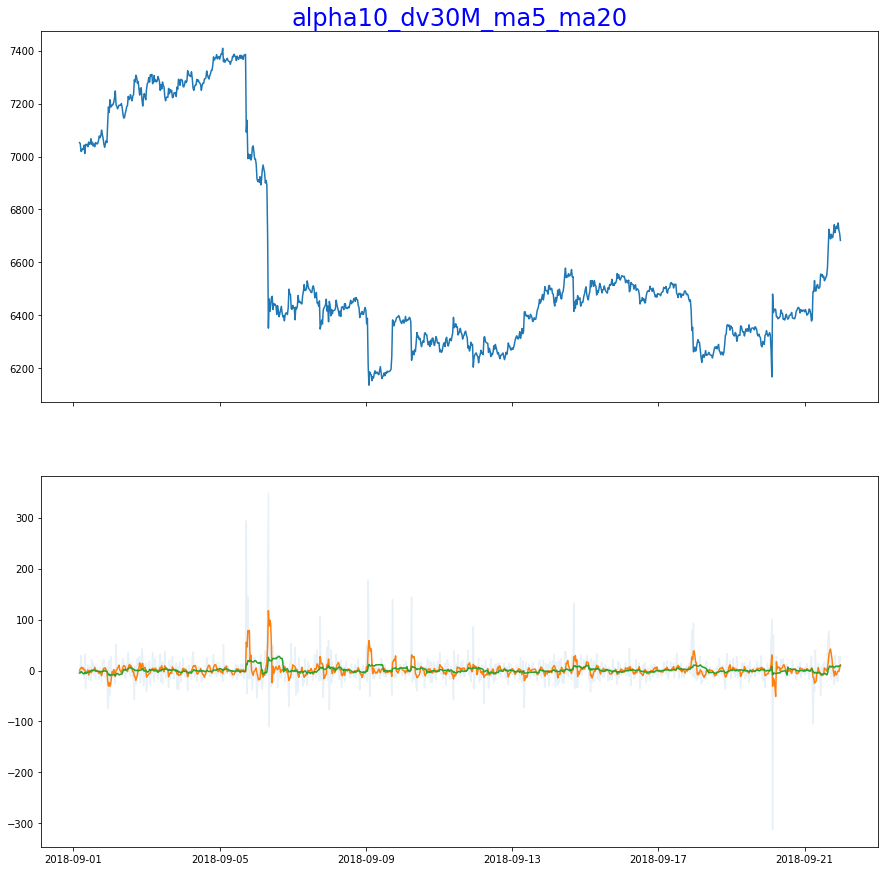

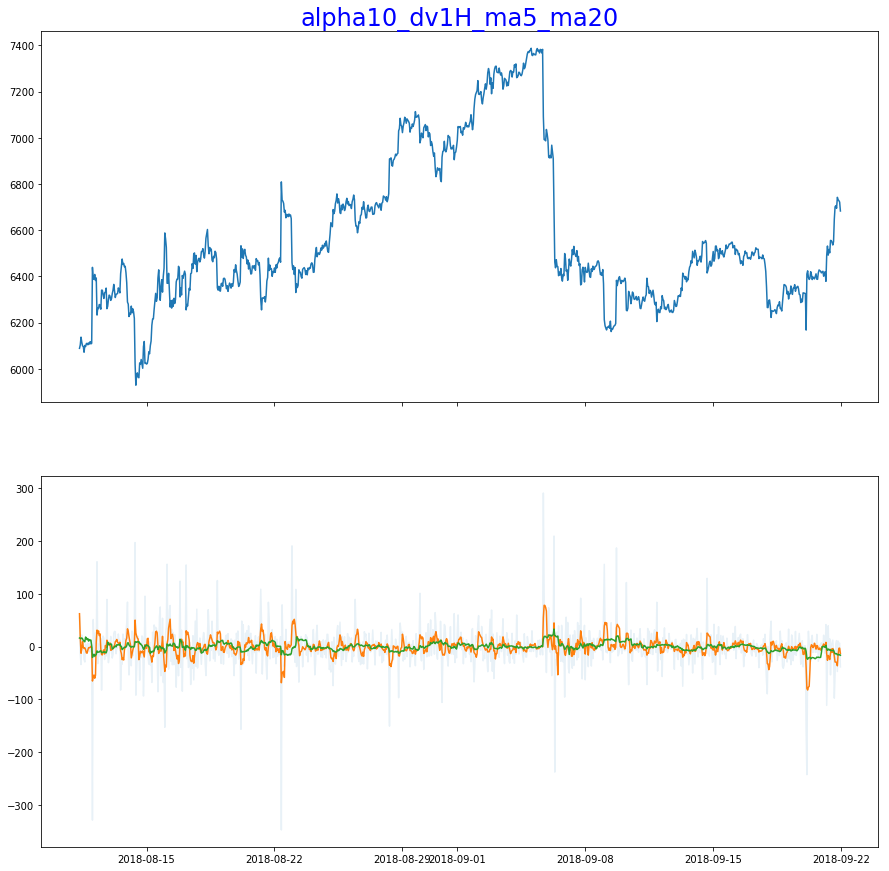

In [4]:
for dvAdd in [dv30M, dv1H]:
    #dvAdd.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True)
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()
    
dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha1_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

import pandas as pd
#alpha1_dv15M是15分钟线，1H是1小时线，ma30和ma60代表对信号进行均线处理和观察是否与价格存在涨跌关系
for name, alpha in alpha1_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',ShortPeriod=5, LongPeriod=20, n=-1000)#橘色短线 绿色长线

In [5]:
# 进场信号
long = dv1H.add_formula("longAlpha1","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha1","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha1","If(shortAlpha1==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha1","If(longAlpha1==2,-1,0)", add_data=True)

dv1H.get_ts('longAlpha1').stack()[dv1H.get_ts('longAlpha1').stack()==2].tail()

/anaconda3/envs/python36/lib/python3.6/site-packages/jaqs/data/py_expression_eval.py:504: RuntimeWarning: invalid value encountered in less_equal
  res = arr <= brr
/anaconda3/envs/python36/lib/python3.6/site-packages/jaqs/data/py_expression_eval.py:495: RuntimeWarning: invalid value encountered in greater_equal
  res = arr >= brr


trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [6]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

from jaqs_fxdayu.research import TimingDigger

tdAlpha1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha001')

TimingSignal(tdAlpha1, dv1H,'longAlpha1','shortAlpha1','closeLongAlpha1','closeShortAlpha1', 100, 0.05, 0.3)

tdAlpha1.create_event_report(sig_type="long_short")

/anaconda3/envs/python36/lib/python3.6/site-packages/jaqs/research/signaldigger/plotting.py:10: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')
/anaconda3/envs/python36/lib/python3.6/site-packages/jaqs_fxdayu/research/timingdigger/digger.py:58: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return x.loc[exit_pos[x.name]].values


Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [7]:
import matplotlib.pyplot as plt
import mpl_finance as mpf
import talib as ta
import numpy as np
import pandas as pd

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

morningstar = dv1H.add_formula('morningstar', "If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
morningstarVolume = dv1H.get_ts('morningstar', date_type='datetime')
morningstarVolume[morningstarVolume['BTCUSDT:binance']==100]

/anaconda3/envs/python36/lib/python3.6/site-packages/jaqs_fxdayu/data/signal_function_mod.py:45: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  candle_pannel = pd.Panel.from_dict(candle_dict)


symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


In [11]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
from matplotlib.pylab import date2num
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
data1H = Time_dict.set_index('datetime')

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  app.launch_new_instance()


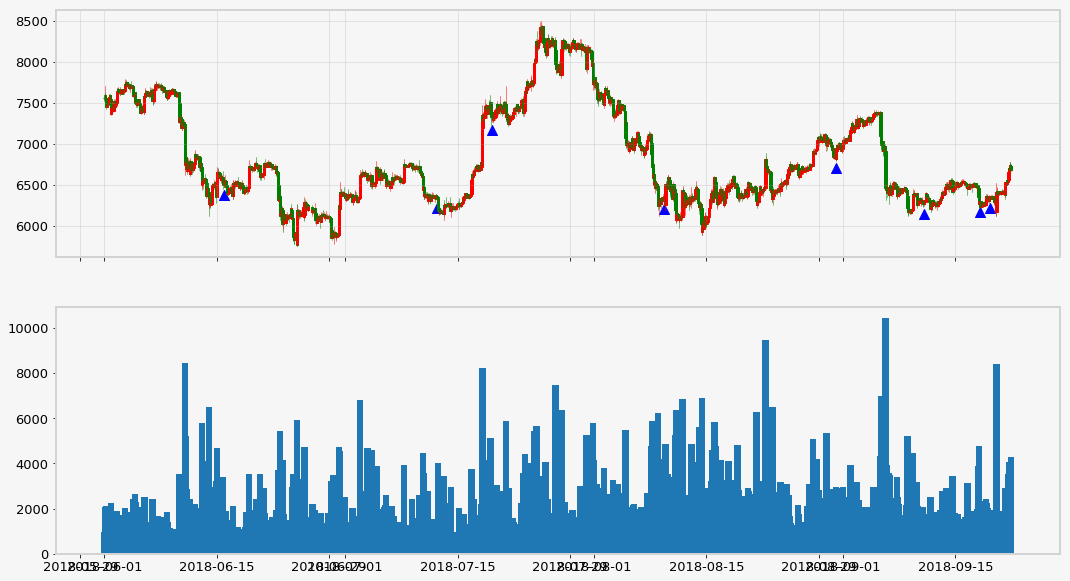

In [12]:
morningstarVolumeX = morningstarVolume[morningstarVolume['BTCUSDT:binance']==100].index

morningstarVolumeY = data1H.loc[morningstarVolumeX].low-100
draw_candle(candle, morningstarVolumeX, morningstarVolumeY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


### Factor One: MACD

##### MACD is called the difference between the moving average, which is developed from the double exponential moving average, which gets the fast line dif by the fast exponential moving average (EMA12) minus the slow exponential moving average (EMA26), and then the MACD column with 2x (the 9th weighted moving average DEA of the fast line dif-dif). The meaning of MACD is basically the same as that of double moving average, that is, it is more convenient to read the current multi-empty state and the possible development trend of stock price by the discrete and polymerization of fast and slow averages. When the MACD turns from a negative number to a positive number, it is a signal to buy. When the MACD shifts from a positive number to a negative number, it is a signal to sell. When the MACD changes at a large angle, the gap between the fast moving average and the slow moving average opens very quickly, representing a shift in the market trend.

##### Calculation method:

##### Calculation method MACD in the application should first calculate the fast (generally selected 12th) moving average and slow (generally selected 26th) moving average. These two values are used as the basis for measuring the "difference between values" between the two (fast and slow lines). The so-called "difference value" (DIF), the 12th EMA value minus the 26th EMA value. So, in the ongoing rally, 12th EMA is above EMA on 26th. The positive difference away value (+DIF) will grow. Conversely, in the decline, the difference in value may become negative (-DIF), but also more and more large. As for the market began to turn, positive or negative difference to reduce the value to a certain extent, only really is the signal of market reversal. The inverted signal of the MACD is defined as the 9th moving average of the "Difference value" (9th EMA). In the calculation formula of the similarities and differences of the MACD, the weight value of the t+1 trading day is added respectively.

In [ ]:
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

## 加freq参数
path = r'../min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

dv1H.add_formula('MACD',"Ta('EMA',0,0,0,0,close,0,12)-Ta('EMA',0,0,0,0,close,0,26)",add_data=True)
dv1H.add_formula('MACD_Signal',"Ta('EMA',0,0,0,0,MACD,0,9)",add_data=True)
dv1H.add_formula('MACD_Hist',"(MACD-MACD_Signal)",add_data=True)

import matplotlib.pyplot as plt
import pandas as pd

def Plot_Mean(dv, MACD_Hist, MACD_Signal,MACD,chart_name='dv1H_MACD', n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(MACD_Hist.iloc[n:],color='blue',alpha=1)
    ax1.plot(MACD_Signal.iloc[n:],color='green',alpha=0.3)
    ax1.plot(MACD.iloc[n:],color='red',alpha=0.3)
    ax1.hlines(0, MACD.iloc[n:].index[0], MACD.iloc[n:].index[-1], alpha=0.4, linestyle='--')
    #ax1.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:],color='orange')
    #ax1.plot(pd.Series(BBI.rolling(ShortPeriod).mean(), index=BBI.index).iloc[n:],color='orange')
    #ax1.plot(pd.Series(BBI.rolling(LongPeriod).mean(), index=BBI.index).iloc[n:],color='g')
    # plt.savefig(chart_name)
    plt.show()


    
MACD=dv1H.get_ts('MACD', date_type='datetime') 
MACD_Signal=dv1H.get_ts('MACD_Signal', date_type='datetime') 
MACD_Hist=dv1H.get_ts('MACD_Hist', date_type='datetime') 
#dv_dict = {'MACD_dv30M':dv30M,'MACD_dv1H':dv1H}
#MACD_dict = {n: dv.get_ts('MACD_Hist', date_type='datetime') for n, dv in dv_dict.items()}

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#读取数据
from jaqs_fxdayu.data.dataservice import LocalDataService
from jaqs_fxdayu.data.hf_dataview import HFDataView
ds = LocalDataService()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
             'symbol': 'BTCUSDT:binance',
             'freq': '1H',
             'start_date':20180601000000}
Time_dict = ds.bar_reader(path,props)

dv = HFDataView()
dv.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


In [4]:
#定义第一个因子MACD
dv.add_formula('EMA12', "Ta('EMA',0,0,0,0,close,0,12)", add_data = True);
dv.add_formula('EMA26', "Ta('EMA',0,0,0,0,close,0,26)", add_data = True);
dv.add_formula('DIF', "EMA12 - EMA26", add_data = True);
dv.add_formula('DEA', "Ta('EMA',0,0,0,0,DIF,9)", add_data = True);
dv.add_formula('MACD', "2*(DIF-DEA)", add_data = True);

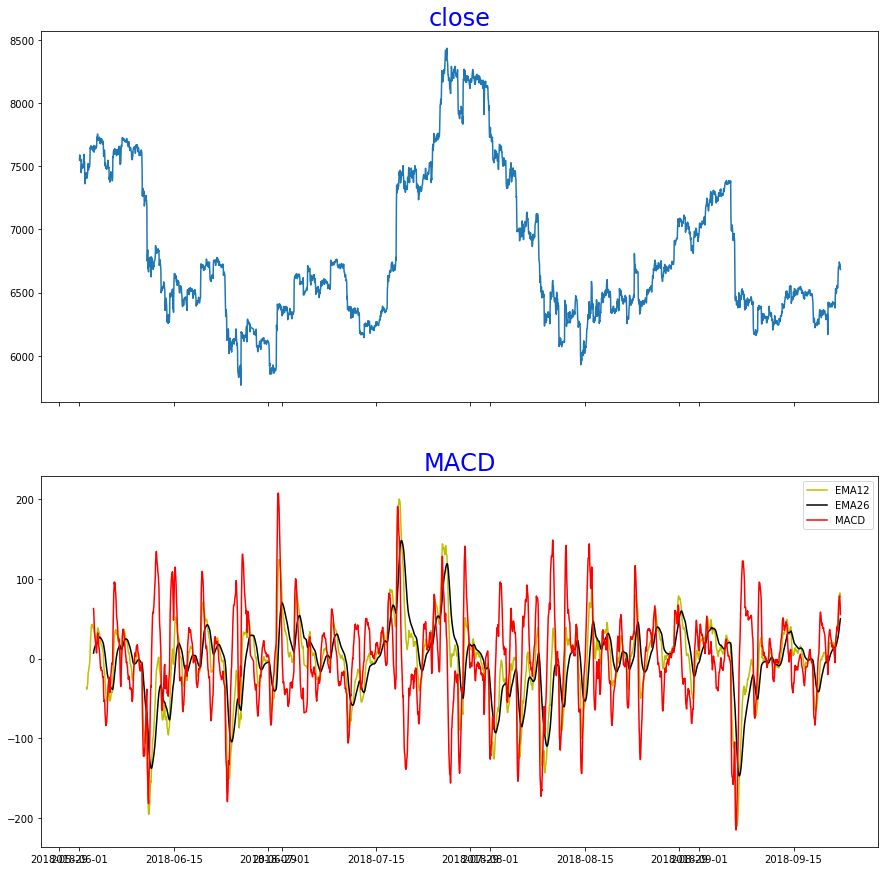

In [5]:
#对MACD绘图
import matplotlib.pyplot as plt
import pandas as pd
fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0])
ax.set_title('close',fontsize=24,color='b') 
ax1.plot(dv.get_ts('DIF', date_type='datetime').iloc[:,0],'y',label='EMA12')
ax1.plot(dv.get_ts('DEA', date_type='datetime').iloc[:,0],'k',label='EMA26')
ax1.plot(dv.get_ts('MACD', date_type='datetime').iloc[:,0],'r',label='MACD')
ax1.set_title('MACD',fontsize=24,color='b')
ax1.legend()
plt.show()

##### Determine:

* 1、当DIF和MACD均大于0并向上移动时，一般表示为股市处于多头行情中，可以买入或持股； 
* 2、当DIF和MACD均小于0并向下移动时，一般表示为股市处于空头行情中，可以卖出股票或观望
* 3、当DIF和MACD均大于0但都向下移动时，一般表示为股票行情处于退潮阶段，股票将下跌，可以卖出股票和观望
* 4、DIF和MACD均小于0时但向上移动时，一般表示为行情即将启动，股票将上涨，可以买进股票或持股待涨
* 现象： DIF趋势滞后；该均值趋势法可以采用金叉死叉思路进行进出场的判断信号。

### Factor Two: CMO

##### EMA (exponential Moving Average) is the exponential moving average. Also known as the EXPMA indicator, it is also a trend class indicator, the exponential moving average is the exponential decrement weighted moving average. After understanding the meaning of MA, ema, you can understand its use, simply put, when to compare the relationship between the value and the average price, with Ma on it, and to compare the average price of the trend speed, with EMA more stable; sometimes, when the mean value is not important, also use EMA to smooth and beautiful curves.

##### Calculation method:

##### EMAtoday=α * Pricetoday + ( 1 - α ) * EMAyesterday

##### alpha is a smoothing index and is generally taken as 2/(n+1). When calculating the MACD indicator, n in the EMA calculation is generally selected for 12 and 26 days, so the alpha corresponds to 2/13 and 2/27. When the formula is consistently recursive until EMA1 appears, EMA1 is not defined. There are several different methods for EMA1 values, typically taking EMA1 as Price1, and the other technique is to take the EMA1 value to the mean of the beginning 4 to 5 values.

In [17]:
#重新读取数据
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from jaqs_fxdayu.data.dataservice import LocalDataService

ds = LocalDataService()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'close,low,high',
         'symbol': 'BTCUSDT:binance', 
         'freq': '4H',
         'start_date':20180601000000}
Time_dict = ds.bar_reader(path,props)

In [18]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [19]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-1000:])
    ax1.plot(alpha.iloc[-1000:])
    # plt.savefig('good')
    plt.show()

In [20]:
EMA10_J = dv.add_formula('EMA10_J', 
                         "Ta('EMA',0,0,0,0,close,0,10)",
                         add_data=True)
ema_plot = dv.get_ts('EMA10_J', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')

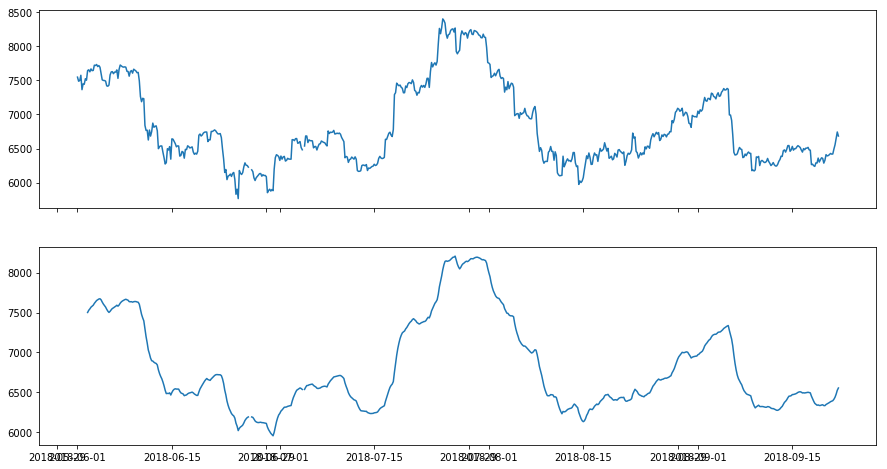

In [21]:
plot_chart(close, ema_plot)

# 5、Observe two factors, and what is the connection with the price map, if it is a candlestick chart, what is the connection with the volume, how to find the corresponding signal, put forward their own signal into the appearance of the hypothesis. (The signal hypothesis of two factors is completed separately)

Signal Inlet hypothesis: Can learn from Mastatiscresearch, but do not limit the idea of thinking to the average, you can observe other phenomena on the market to write signal hypothesis, but also to meet the signal of multiple factors at the same time to design signal hypothesis and so on.


##### MACD signal：

##### Based on the above analysis of MACD, you can refer to its meaning to define the following entry and exit conditions to enter: When diff and Dea are above the 0 line, diff upward break through the DEA, indicating that the stock market is in a strong, the share price will rise again, can be added to buy stocks or shareholding to rise.

Appearance: When diff and Dea are under the 0 line, diff down the DEA, indicating that the stock market is a weak market, the share price decline is not stop, should continue to close the position of the bitcoin.

##### EMA signal：

##### In general, if EMA rises, the way to indicate that it can be manipulated is to do more or wait, and if EMA drops, the way to indicate that it is operable is to be short or wait, and if the EMA is narrow, the EMA reference is of little significance.

However, the price fluctuation of bitcoin is too large, the simple use of EMA rise or fall to guide the trade is overwhelmed, because bitcoin's EMA line is too much is a flat line, its obvious tilt direction is sharp price fluctuations, this situation is often by luck to encounter.

##### The more important function of the EMA line is to use the pressure line and the support line. The rising EMA line can look at the price of the support line, the falling EMA line is the price of the pressure line. You can use the EMA line to do the stop-loss line, such as doing a long, price as you expect to rise, then your stop loss level is placed below the EMA line of the day, if the late period is still rising, the EMA line is on the rise, then your stop loss level will follow up. In turn, shorting can also use the EMA line to find the closing point, the short stop loss position is placed above the EMA line a little bit. Another usage is to use EMA lines to find entry or emptying points. Because the price is always fluctuating, but the rising EMA line indicates the fluctuating downline, when in the rising EMA line, once the price touches the EMA line down, you can buy, and place the stop loss position below the EMA point.

Instead, the falling EMA line acts as a fluctuating online, and when the price touches the EMA line, it can be emptied.

# 6、Implementation of assumptions

Using the three performance tables of timingsignal final output long, short, long_short

In [23]:
# 因子一：MACD
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

#加freq参数
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

data1H = Time_dict.set_index('datetime')

import matplotlib.pyplot as plt
import pandas as pd

def Plot_Mean(dv, alpha, Diff, Dea, chart_name='dv_MACD', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=1)
    ax1.plot(Diff.iloc[n:], alpha=0.4)
    ax1.plot(Dea.iloc[n:], alpha=0.4)
    ax1.hlines(0, MACD.iloc[n:].index[0], MACD.iloc[n:].index[-1], alpha=0.4)
    plt.show()
    
def Plot_Mean1(dv, alpha1, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[n:,0])
    ax1.plot(alpha1.iloc[n:], 'g',alpha=1)
    ax1.hlines(0, alpha1.iloc[n:].index[0], alpha1.iloc[n:].index[-1], 'r',alpha = 0.4)
    ax1.hlines(100, alpha1.iloc[n:].index[0], alpha1.iloc[n:].index[-1], alpha=0.4)
    ax1.hlines(-100, alpha1.iloc[n:].index[0], alpha1.iloc[n:].index[-1], alpha=0.4)
    plt.show()
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))
dv1H.add_formula("CCI_J","Ta('CCI',0,0,high,low,close,0,10)" ,add_data=True)
dv1H.add_formula('MA_5',"Ta('MA',0,0,0,0,close,0,5)", add_data=True)
dv1H.add_formula('MA_20',"Ta('MA',0,0,0,0,close,0,10)", add_data=True)
CCI = dv1H.get_ts('CCI_J', date_type='datetime')

# 设定进出场条件
long = dv1H.add_formula('long',"If(CCI_J > 100,2,0)", add_data=True)
short = dv1H.add_formula('short',"If(CCI_J < -100,-2,0)", add_data=True)
closeLong = dv1H.add_formula('closeLong','If(MA_5 > MA_20&&(Delay(MA_5,1)<Delay(MA_20,1)),1,0)', add_data=True)
closeShort = dv1H.add_formula("closeShort",'If(MA_5 < MA_20&&(Delay(MA_5,1)>Delay(MA_20,1)),1,0)', add_data=True)

Initialize dataview success.


In [24]:
#计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv1H, 100, 0.15, 0.7)

/anaconda3/envs/python36/lib/python3.6/site-packages/jaqs/research/signaldigger/plotting.py:10: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


Nan Data Count (should be zero) : 0;  Percentage of effective data: 15%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 16%


In [25]:
tdMaStatistic.create_event_report(sig_type="long")
tdMaStatistic.create_event_report(sig_type="short")
tdMaStatistic.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               12.271   -9.924   -0.548
p-value               0.000    0.000    0.584
mean                  0.014   -0.014   -0.001
std                   0.016    0.021    0.024
info_ratio            0.883   -0.678   -0.027
skewness              2.217   -3.016   -1.011
kurtosis              6.549   10.018    7.082
pct5                  0.001   -0.049   -0.036
pct25                 0.003   -0.015   -0.007
pct50                 0.009   -0.007   -0.001
pct75                 0.021   -0.003    0.009
pct95                 0.047   -0.001    0.032
occurance           194.000  215.000  409.000
win_ratio               NaN      NaN    0.474
win_mean/loss_mean      NaN      NaN    1.013
*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               22.822  -18.375    2.312
p-value               0.000    0.000    0.021
mean                  0.062   -0.046    0.007
std       

MACD: As can be seen from the statistics, MACD as a factor is statistically significant (p value close to 0), but only through the MACD up and down through the 0 value to buy and sell the effect is only poor, win ratio slightly higher than the 0.4,win/lose mean than a little more than 1. The main reason may be because MACD as an average indicator, has a relatively serious lag, although it can predict the price trend, but it is difficult to determine the occurrence and duration of the trend, in addition, the selection of data in 1H, MACD is mainly shown in the long-term trend, so there will be a lot of null values in the inbound and outbound points, This is due to the selection of data.

Generally speaking, only MACD to buy and sell, the effect is not too good.

CMO：From the performance point of view, whether it is to see more or bearish, are loss greater than win, it can be seen that the CMO strategy applicable to BTCUSDT on the EOSUSDT of the use of the effect becomes very poor.
Therefore, the applicability of the strategy of grabbing Overbought super selling points through the CMO is worse than that of MACD.

However, the above comparison is at the same data time length, perhaps after changing the parameters will have different effects.